In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import gc
import sys
from tqdm import tqdm
from pprint import pprint
import pandas as pd
import IPython.display as ipd
import seaborn as sns
from einops import reduce

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.chdir('../IConNet/')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
checkpoint_path = '../backup_models_20240303/models_esd4/esd4_m13_best_92epoch.pt'
pretrained_model = torch.load(checkpoint_path)
pretrained_model

OrderedDict([('fe_blocks.blocks.0.block.layer.lowcut_bands',
              tensor([[0.0000],
                      [0.0036],
                      [0.0075],
                      [0.0117],
                      [0.0162],
                      [0.0211],
                      [0.0264],
                      [0.0322],
                      [0.0384],
                      [0.0451],
                      [0.0524],
                      [0.0603],
                      [0.0688],
                      [0.0780],
                      [0.0880],
                      [0.0988],
                      [0.1105],
                      [0.1231],
                      [0.1368],
                      [0.1516],
                      [0.1676],
                      [0.1849],
                      [0.2036],
                      [0.2239],
                      [0.2458],
                      [0.2696],
                      [0.2952],
                      [0.3230],
                      [0.3531],
           

In [6]:
from IConNet.nn.model import M13
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m13.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M13(config=model_config,
           n_input=1, n_output=4)
model

{'name': 'M13', 'description': 'FirConv with fftconv', 'fe': {'n_block': 2, 'n_channel': [128, 32], 'kernel_size': [511, 127], 'stride': [8, 2], 'window_k': [2, 9], 'mel_resolution': 4, 'residual_connection_type': 'stack', 'pooling': 'mean', 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [256, 256], 'norm_type': 'LayerNorm'}}


M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm):

In [7]:
model.load_state_dict(pretrained_model)

<All keys matched successfully>

In [11]:
pretrained_model['fe_blocks.blocks.0.block.layer.lowcut_bands']

tensor([[0.0000],
        [0.0036],
        [0.0075],
        [0.0117],
        [0.0162],
        [0.0211],
        [0.0264],
        [0.0322],
        [0.0384],
        [0.0451],
        [0.0524],
        [0.0603],
        [0.0688],
        [0.0780],
        [0.0880],
        [0.0988],
        [0.1105],
        [0.1231],
        [0.1368],
        [0.1516],
        [0.1676],
        [0.1849],
        [0.2036],
        [0.2239],
        [0.2458],
        [0.2696],
        [0.2952],
        [0.3230],
        [0.3531],
        [0.3856],
        [0.4207],
        [0.4588],
        [0.0000],
        [0.0054],
        [0.0111],
        [0.0171],
        [0.0235],
        [0.0303],
        [0.0375],
        [0.0452],
        [0.0534],
        [0.0620],
        [0.0712],
        [0.0809],
        [0.0912],
        [0.1022],
        [0.1138],
        [0.1261],
        [0.1392],
        [0.1531],
        [0.1679],
        [0.1835],
        [0.2002],
        [0.2178],
        [0.2365],
        [0

In [12]:
sr = 16000
pretrained_model['fe_blocks.blocks.0.block.layer.lowcut_bands'] * sr

tensor([[   0.0000],
        [  57.3504],
        [ 119.3980],
        [ 186.5504],
        [ 259.1813],
        [ 337.7706],
        [ 422.7990],
        [ 514.7941],
        [ 614.3267],
        [ 722.0144],
        [ 838.5254],
        [ 964.5825],
        [1100.9680],
        [1248.5280],
        [1408.1779],
        [1580.9092],
        [1767.7926],
        [1969.9880],
        [2188.7500],
        [2425.4363],
        [2681.5146],
        [2958.5750],
        [3258.3357],
        [3582.6567],
        [3933.5510],
        [4313.1953],
        [4723.9453],
        [5168.3491],
        [5649.1646],
        [6169.2808],
        [6730.6343],
        [7341.1577],
        [   0.0000],
        [  85.8391],
        [ 176.9413],
        [ 273.6428],
        [ 375.8918],
        [ 485.1537],
        [ 600.7393],
        [ 723.4119],
        [ 853.6060],
        [ 991.7828],
        [1138.4316],
        [1294.0721],
        [1459.2555],
        [1634.5669],
        [1820.6272],
        [2018

In [13]:
pretrained_model['fe_blocks.blocks.0.block.layer.bandwidths'] * sr

tensor([[ 57.3530],
        [ 62.0528],
        [ 67.1316],
        [ 72.6378],
        [ 78.5893],
        [ 85.0284],
        [ 91.9951],
        [ 99.5326],
        [107.6874],
        [116.5110],
        [126.0571],
        [136.3855],
        [147.5600],
        [159.6714],
        [172.7309],
        [186.8834],
        [202.1955],
        [218.7621],
        [236.6861],
        [256.0787],
        [277.0602],
        [299.7607],
        [324.3212],
        [350.8941],
        [379.6442],
        [410.7498],
        [444.4041],
        [480.8158],
        [520.2108],
        [562.6916],
        [608.9487],
        [658.8421],
        [ 85.8391],
        [ 91.1022],
        [ 96.6880],
        [102.6822],
        [108.9081],
        [115.5856],
        [122.6726],
        [130.1941],
        [138.1768],
        [146.6489],
        [155.6405],
        [165.1834],
        [175.3114],
        [186.0603],
        [197.4684],
        [209.5759],
        [222.4257],
        [236.0634],


In [15]:
pretrained_model.keys()

odict_keys(['fe_blocks.blocks.0.block.layer.lowcut_bands', 'fe_blocks.blocks.0.block.layer.bandwidths', 'fe_blocks.blocks.0.block.layer.window_params', 'fe_blocks.blocks.0.block.layer.mesh_freq', 'fe_blocks.blocks.0.block.layer.shift_freq', 'fe_blocks.blocks.1.block.layer.lowcut_bands', 'fe_blocks.blocks.1.block.layer.bandwidths', 'fe_blocks.blocks.1.block.layer.window_params', 'fe_blocks.blocks.1.block.layer.mesh_freq', 'fe_blocks.blocks.1.block.layer.shift_freq', 'cls_head.blocks.0.norm.weight', 'cls_head.blocks.0.norm.bias', 'cls_head.blocks.0.layer.weight', 'cls_head.blocks.0.layer.bias', 'cls_head.blocks.1.norm.weight', 'cls_head.blocks.1.norm.bias', 'cls_head.blocks.1.layer.weight', 'cls_head.blocks.1.layer.bias', 'cls_head.output_layer.weight', 'cls_head.output_layer.bias'])

In [52]:
dataset_name = 'ravdess'
experiment_prefix = 'trillsson_fusion'
log_dir = f'../{experiment_prefix}_models/{dataset_name}/'
data_dir = f'../data/data_preprocessed/{dataset_name}/features/'
sr = 16000

data_x = np.load(f'{data_dir}{dataset_name}.audio16k.npy', allow_pickle=True)
data_x_emb = np.load(f'{data_dir}{dataset_name}.embedding.trillsson.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}{dataset_name}.label_emotion.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}{dataset_name}.classnames.npy', allow_pickle=True)
print(classnames)
print(data_x.shape, data_x_emb.shape)
print(data_y.shape, np.unique(data_y))

['neutral' 'calm' 'happy' 'sad' 'angry' 'fearful' 'disgust' 'surprised']
(1440,) (1440, 1024)
(1440,) [0 1 2 3 4 5 6 7]


In [17]:
labels = ['ang', 'neu', 'sad', 'hap']

def label_filter(idx):
    return classnames[idx][:3] in labels

def label_to_index(idx):
    return labels.index(classnames[idx][:3])
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_x_emb = data_x_emb[filtered_idx]
data_y = [label_to_index(idx) for idx in data_y[filtered_idx]]
print(data_x.shape)

(672,)


In [19]:
latents = []
model.to(device)
with torch.no_grad():
    for d in data_x[:3]:
        l = model.fe_blocks(torch.tensor(d, device=device)[None, None, :])
        latents.append(l.squeeze())

In [22]:
for l in latents:
    print(l.shape)

torch.Size([161, 3304])
torch.Size([161, 3337])
torch.Size([161, 3270])


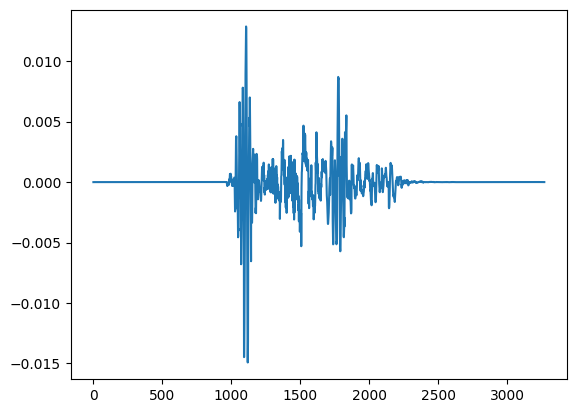

In [23]:
plt.plot(l[0].cpu())

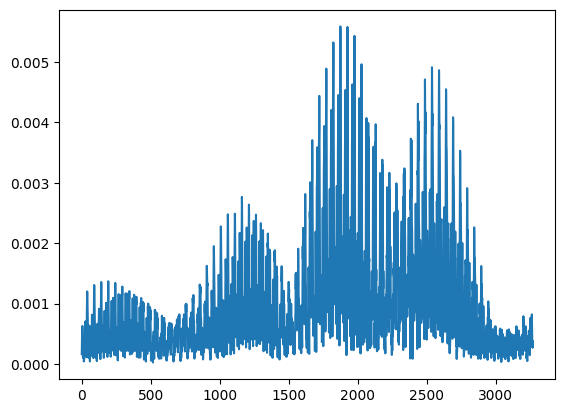

In [31]:
plt.plot(l[1].cpu())

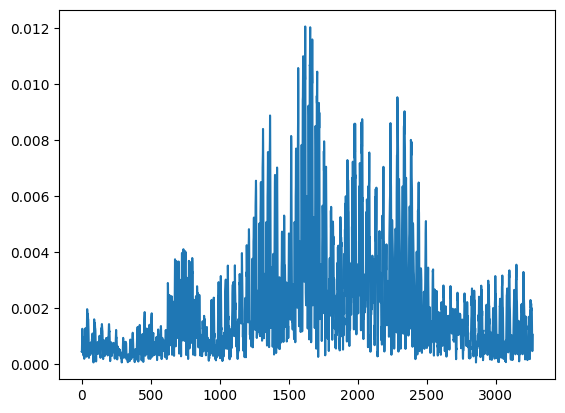

In [32]:
plt.plot(l[2].cpu())

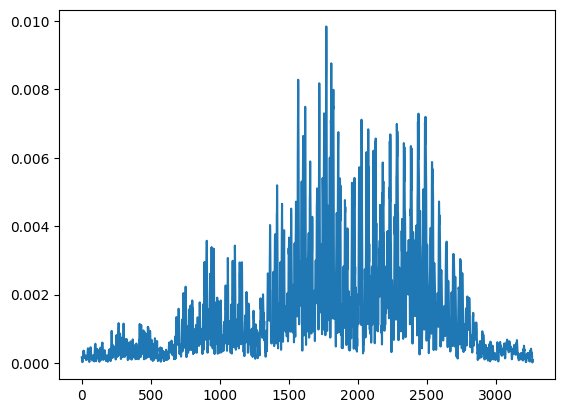

In [33]:
plt.plot(l[3].cpu())

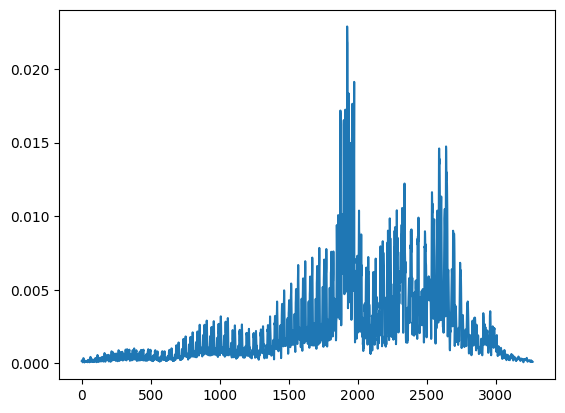

In [27]:
plt.plot(l[10].cpu())

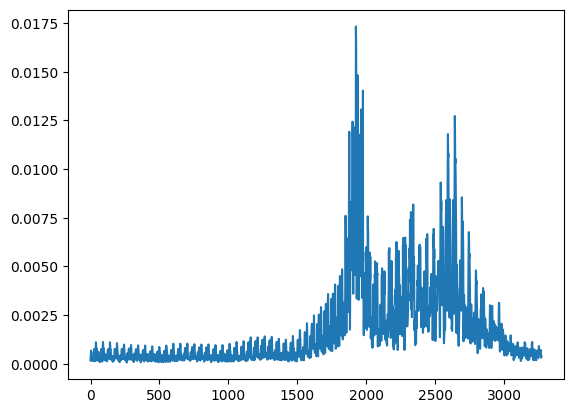

In [28]:
plt.plot(l[13].cpu())

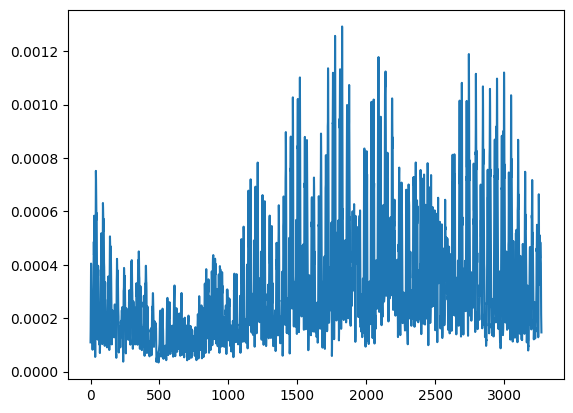

In [29]:
plt.plot(l[88].cpu())

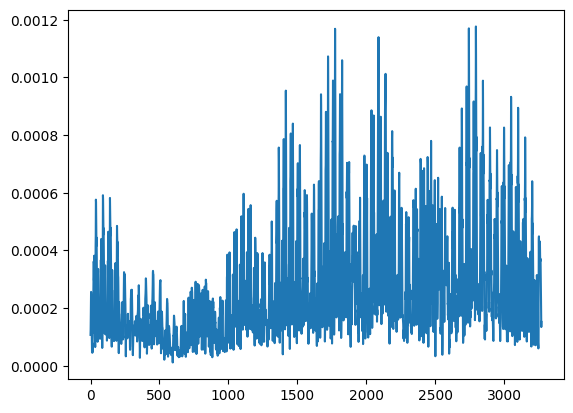

In [26]:
plt.plot(l[120].cpu())

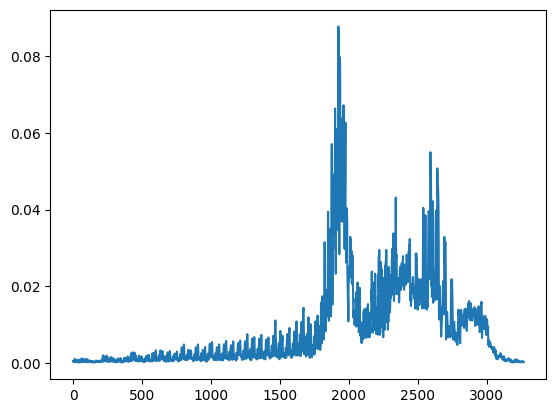

In [25]:
plt.plot(l[128].cpu())

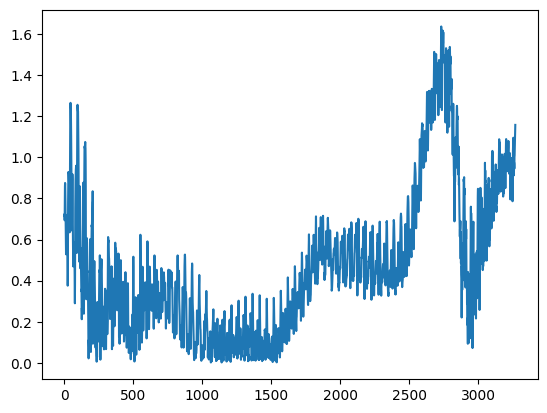

In [30]:
plt.plot(l[-10].cpu())

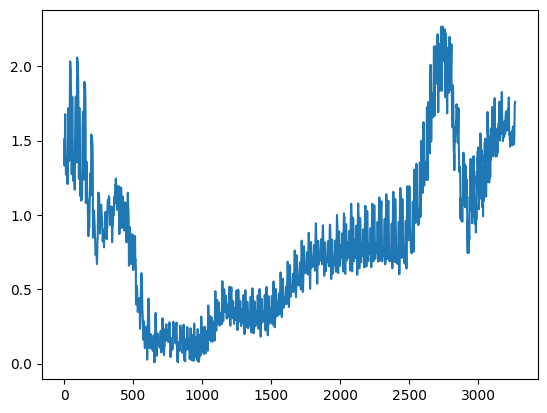

In [24]:
plt.plot(l[-1].cpu())

In [34]:
latents = []
model.to(device)
with torch.no_grad():
    for d in data_x:
        l = model.fe_blocks(torch.tensor(d, device=device)[None, None, :])
        latents.append(l.squeeze().cpu().numpy())

In [35]:
latents

[array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [7.12840265e-05, 6.83630205e-05, 1.29213528e-04, ...,
         1.30764034e-04, 1.46974111e-04, 1.56866619e-04],
        [2.85326503e-04, 2.21455266e-04, 9.27999790e-05, ...,
         3.18595645e-04, 2.33026512e-04, 1.14790324e-04],
        ...,
        [6.07184887e-01, 5.86630166e-01, 5.61354697e-01, ...,
         6.81303024e-01, 7.24085867e-01, 7.06817389e-01],
        [4.30266142e-01, 4.24538165e-01, 4.33580309e-01, ...,
         5.09435117e-01, 5.45926094e-01, 5.38758814e-01],
        [1.14144623e+00, 1.13687134e+00, 1.12855780e+00, ...,
         1.14583755e+00, 1.20537984e+00, 1.24767566e+00]], dtype=float32),
 array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [6.0861511e-04, 6.4787088e-04, 6.1993441e-04, ..., 3.0399582e-04,
         2.5739838e-04, 2.5978062e-04],
        [8.7477418e-04

In [36]:
print(f'{data_dir}{dataset_name}')

../data/data_preprocessed/ravdess/features/ravdess


In [43]:
np.save(
    f'{data_dir}{dataset_name}.embedding.m13_esd_pt92.npy', 
    np.array(latents, dtype=object), allow_pickle=True)

ValueError: could not broadcast input array from shape (161,3304) into shape (161,)

In [44]:
import pickle

In [51]:
with open(f'{data_dir}{dataset_name}.embedding.m13_esd_pt92.label4.npy', 'wb') as f:
    pickle.dump(latents, f)

In [53]:
latents = []
model.to(device)
with torch.no_grad():
    for d in data_x:
        l = model.fe_blocks(torch.tensor(d, device=device)[None, None, :])
        latents.append(l.squeeze().cpu().numpy())

In [54]:
len(latents)

1440

In [55]:
with open(f'{data_dir}{dataset_name}.embedding.m13_esd_pt92.npy', 'wb') as f:
    pickle.dump(latents, f)

In [46]:
emb = np.load(f'{data_dir}{dataset_name}.embedding.m13_esd_pt92.npy', allow_pickle=True)

In [56]:
model.cpu()

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm):

## CREMA-D

In [8]:
dataset_name = 'crema_d'
experiment_prefix = "scb7"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/'
data_dir = "../data/data_preprocessed/"
dataset_config_path = f'config/dataset/{dataset_name}.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)

{'name': 'crema_d', 'dataset_class': 'WaveformDataset', 'root': 'crema_d/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label6', 'feature_name': 'audio16k', 'num_classes': 6, 'label_values': ['neu', 'hap', 'sad', 'ang', 'fea', 'dis'], 'classnames': ['neu', 'hap', 'sad', 'ang', 'fea', 'dis'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}


In [9]:
data_dir = f'../data/data_preprocessed/{dataset_name}/features/'
data_x = np.load(f'{data_dir}{dataset_name}.audio16k.npy', allow_pickle=True)

In [10]:
latents = []
model.to(device)
with torch.no_grad():
    for d in data_x[:3]:
        l = model.fe_blocks(torch.tensor(d, device=device)[None, None, :])
        latents.append(l.squeeze())

In [11]:
for l in latents:
    print(l.shape)

torch.Size([161, 2136])
torch.Size([161, 2336])
torch.Size([161, 2203])


In [12]:
latents = []
model.to(device)
with torch.no_grad():
    for d in data_x:
        l = model.fe_blocks(torch.tensor(d, device=device)[None, None, :])
        latents.append(l.squeeze().cpu().numpy())

In [13]:
print(len(latents))
print(f'{data_dir}{dataset_name}')

7442
../data/data_preprocessed/crema_d/features/crema_d


In [15]:
import pickle

In [16]:
with open(f'{data_dir}{dataset_name}.embedding.m13_esd_pt92.npy', 'wb') as f:
    pickle.dump(latents, f)

In [17]:
del latents, data_x